## **Importing libraries**

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Stratified Sample split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 47
np.random.seed(47)

## **Importing the datasets**

In [3]:
train = pd.read_csv('data/churn-bigml-80.csv')
test = pd.read_csv('data/churn-bigml-20.csv')

## **Data Cleaning**

In [4]:
train.columns = [x.lower().replace(" ","_") for x in train.columns]
test.columns = [x.lower().replace(" ","_") for x in train.columns]

In [5]:
print(f"The train data contains {train.isnull().sum().sum()} missing data")
print(f"The test data contains {test.isnull().sum().sum()} missing data")

The train data contains 0 missing data
The test data contains 0 missing data


In [6]:
churn_encode = {'False':0, 'True': 1}
train['churn'] = train['churn'].astype(int)
test['churn'] = test['churn'].astype(int)

train['area_code'] = train['area_code'].astype(str) 
test['area_code'] = test['area_code'].astype(str) 

In [7]:
X_train = train.drop(['churn', 'state'], axis = 1)
y_train = train['churn'].copy()

X_test = test.drop(['churn', 'state'], axis = 1)
y_test = test['churn'].copy()

In [8]:
X_train.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


## **Data Exploration**

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2666, 18), (667, 18), (2666,), (667,))

In [10]:
categorical_data = X_train.select_dtypes(include = ['object'])
numerical_data = X_train.select_dtypes(exclude = ['object'])

In [11]:
categorical_data.describe()

,area_code,international_plan,voice_mail_plan
count,2666,2666,2666
unique,3,2,2
top,415,No,No
freq,1318,2396,1933


In [12]:
numerical_data.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [13]:
y_train.value_counts(normalize = True)

0    0.854464
1    0.145536
Name: churn, dtype: float64

## **Call Price Calculation**

In [14]:
call_prices = dict()

call_prices["Day_charge"] = (X_train["total_day_charge"]/ X_train["total_day_minutes"]).mean()
call_prices["Eve_charge"] = (X_train["total_eve_charge"]/ X_train["total_eve_minutes"]).mean()
call_prices["Night_charge"] = (X_train["total_night_charge"]/ X_train["total_night_minutes"]).mean()
call_prices["Intl_charge"] = (X_train["total_intl_charge"]/ X_train["total_intl_minutes"]).mean()

In [15]:
call_prices

{'Day_charge': 0.17000322140576996,
 'Eve_charge': 0.08500139200814222,
 'Intl_charge': 0.2700548437359162,
 'Night_charge': 0.04500046561728902}

In [16]:
X_train.iloc[0, :]

account_length              128
area_code                   415
international_plan           No
voice_mail_plan             Yes
number_vmail_messages        25
total_day_minutes         265.1
total_day_calls             110
total_day_charge          45.07
total_eve_minutes         197.4
total_eve_calls              99
total_eve_charge          16.78
total_night_minutes       244.7
total_night_calls            91
total_night_charge        11.01
total_intl_minutes         10.0
total_intl_calls              3
total_intl_charge           2.7
customer_service_calls        1
Name: 0, dtype: object

## **Data Preparation and Modelling Pipeline**

In [17]:
categorical_col = categorical_data.columns
numerical_col = numerical_data.columns

In [18]:
scale = StandardScaler()
l_encode = LabelEncoder()
oh_encode = OneHotEncoder(sparse = False, drop = "first")

model = XGBClassifier(objective='binary:logistic', max_depth =  10,
          learning_rate = 0.06808766268462589, colsample_bytree = 0.5124699707194202, 
             subsample =  0.4553243247037658, reg_alpha =  1.5936907054484504, random_state = 117)

In [19]:
column_transformer_ = make_column_transformer(
                      (oh_encode , categorical_col),
                      (scale,  numerical_col),
                      remainder = "passthrough")

pipe = make_pipeline(column_transformer_, model)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  Index(['area_code', 'international_plan', 'voice_mail_plan'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 't...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.06808766268462589, max_bin=256,
                       

In [20]:
from sklearn import set_config
set_config(display = "diagram")
column_transformer_

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 Index(['area_code', 'international_plan', 'voice_mail_plan'], dtype='object')),
                                ('standardscaler', StandardScaler(),
                                 Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls'],
      dtype='object'))])

In [21]:
X_train.shape, X_test.shape

((2666, 18), (667, 18))

## **Model Evaluation**

In [22]:
y_pred = pipe.predict(X_test)

In [23]:
print(f"Model Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Model Precision : {precision_score(y_test, y_pred)}")
print(f"Model Recall : {precision_score(y_test, y_pred)}")
print(f"Model F1 : {f1_score(y_test, y_pred)}")

Model Accuracy : 0.9550224887556222
Model Precision : 0.9452054794520548
Model Recall : 0.9452054794520548
Model F1 : 0.8214285714285715


In [24]:
print( classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       572
           1       0.95      0.73      0.82        95

    accuracy                           0.96       667
   macro avg       0.95      0.86      0.90       667
weighted avg       0.95      0.96      0.95       667



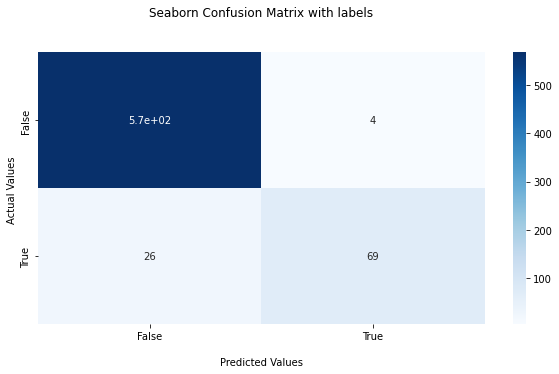

In [25]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10, 5))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## **Saving Model**

In [27]:
with open("churnModel.pkl", "wb") as file:
  pickle.dump((pipe, call_prices), file)